In [9]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [10]:
import torch
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
import seaborn as sns
from tqdm import tqdm
from sophius.train import train_on_gpu_ex
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()

Files already downloaded and verified


In [11]:
from sophius.estimate import LSTMRegressor
from sophius.utils import calc_model_flops

estimator = torch.load('../data/models/estimator_v2.pth').cpu()

def estimate_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator(t).item()

Conv2d       (64, 8, 8)     (3, 3)   (4, 4)  
PReLU        (64, 8, 8)    
MaxPool2d    (64, 3, 3)     (4, 4)   (3, 3)  
BatchNorm2d  (64, 3, 3)    
AvgPool2d    (64, 2, 2)     (3, 3)   (2, 2)  
Flatten      256           
Linear       10            

0.23 MFlops


Loss 63.942: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

val_acc: 0.383 train_acc: 0.421
val_acc* 0.525


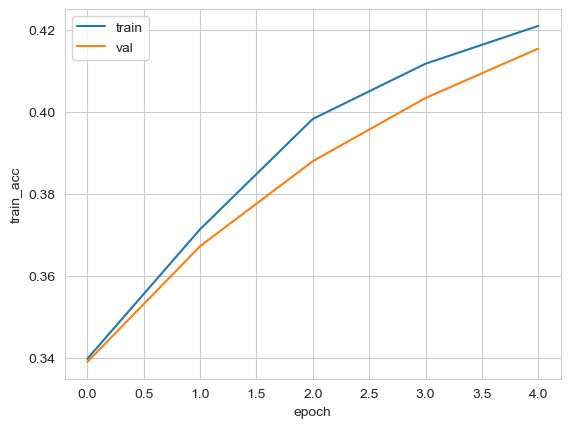

In [12]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), 
    out_shape=10, 
    conv_num=1, 
    lin_num=1,
)

model_tmpl = model_gen.generate_model_tmpl()
model = model_tmpl.instantiate_model().cuda()

print(model_tmpl)
flops = calc_model_flops(model, model_gen.in_shape)['flops']
print(round(flops / 1024 / 1024, 2), 'MFlops')

train_params = {
    'val_size': 10000,
    'batch_size': 1024,
    'num_epoch': 5,
    'random_seed':42,
    'optimizer': 'AdamW',
    'opt_params': {
        'lr': 1e-3,
    },
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },
}

res = train_on_gpu_ex(
    model=model,
    dataset=cifar_gpu,
    verbose=True,
    **train_params,
)
print('val_acc* %.3f' % (estimate_acc(model_tmpl)))

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val');

In [13]:
import torch
torch.cuda.get_device_name()

'NVIDIA RTX A500 Laptop GPU'

In [14]:
from sophius.db import *
from peewee import *

with database:
    database.create_tables([Experiments, Models, Devices, Runs, ModelEpochs])    

In [15]:
exp_params = {**train_params, **{'in_shape': (3, 32, 32), 'out_shape': 10}}

exp, _ = Experiments.get_or_create(**exp_params)
    
Devices.create_table()
dev, _ = Devices.get_or_create(name=torch.cuda.get_device_name())

In [17]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), out_shape=10, 
    conv_num=1, lin_num=1
)

val_acc_threshold = 0.05

for i in tqdm(range(5)):
    model_tmpl = model_gen.generate_model_tmpl()
    model_gpu = model_tmpl.instantiate_model().cuda()
    
    if estimate_acc(model_tmpl) < val_acc_threshold:
        continue
    
    model_info = calc_model_flops(model_gpu, model_gen.in_shape)        
    model, _ = Models.get_or_create(
        hash = encoder.model2hash(model_tmpl),
        flops = model_info['flops'],
        macs = model_info['macs'],
        params = model_info['params'],
    )
        
    epoch_results = train_on_gpu_ex(
        model=model_gpu,
        dataset=cifar_gpu,
        verbose=False,
        **train_params,
    )
    
    run = Runs.create(
        exp_id = exp.id,
        model_id = model.id,
        device_id = dev.id,
        val_acc = epoch_results.val_acc.iloc[-10:].mean(),
        train_acc = epoch_results.train_acc.iloc[-10:].mean(),
        time = epoch_results.time.iloc[-1],
    )

    for _, row in epoch_results.iterrows():
        ModelEpochs.create(
            run_id = run.id,
            loss = row['loss'],
            train_acc = row['train_acc'],
            val_acc = row['val_acc'],
            time = row['time'],
        )    

100%|██████████| 5/5 [00:18<00:00,  3.64s/it]
